# Feed Forward Neural Network Classification Example

**Dataset**: 178 samples, 13 features, 3 classes (wheat categories)

**Network**: 5 hidden layers (sizes: 20, 10, 8, 8, 3), 1 output layer

**Activation Functions**:
- **Sigmoid**: squashes output to [0,1], derivative <= 0.25
- **ReLU**: max(0,x), derivative = 1 for positive inputs

## Load required libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
# ------------------------
# Reproducibility
# ------------------------
np.random.seed(42)


## Load dataset

In [5]:

df = pd.read_csv("classification.csv")

X = df.drop(columns=["label"]).values
y = df["label"].values
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode labels (0,1,2) → one-hot
le = LabelEncoder()
y_encoded = le.fit_transform(y).reshape(-1,1)
encoder = OneHotEncoder(sparse_output=False)  # 
y_onehot = encoder.fit_transform(y_encoded)

In [7]:
X.shape

(210, 7)

## Activation fucntions

In [8]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(a):
    return (a > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

## Neural Network Training Function

In [9]:
def train_ffnn(X, y, lr=0.002, epochs=3000, clip_value=5.0):
    n_samples, n_features = X.shape
    n_classes = y.shape[1]
    hidden_sizes = [20, 10, 8, 8, 3]

    # He initialization
    weights, biases = [], []
    prev_size = n_features
    for h in hidden_sizes:
        W = np.random.randn(prev_size, h) * np.sqrt(2.0 / prev_size)
        b = np.zeros((1, h))
        weights.append(W)
        biases.append(b)
        prev_size = h

    W_out = np.random.randn(prev_size, n_classes) * np.sqrt(2.0 / prev_size)
    b_out = np.zeros((1, n_classes))

    # Keep copies of initial weights for analysis
    init_hidden_w = [W.copy() for W in weights]
    init_out_w = W_out.copy()

    losses, accuracies, grad_mags = [], [], [[] for _ in hidden_sizes]

    for epoch in range(epochs):
        # Forward pass
        activations = [X]
        for W, b in zip(weights, biases):
            Z = activations[-1] @ W + b
            A = relu(Z)
            activations.append(A)

        Z_out = activations[-1] @ W_out + b_out
        probs = softmax(Z_out)

        # Cross-entropy loss
        loss = -np.mean(np.sum(y * np.log(probs + 1e-15), axis=1))
        losses.append(loss)

        # Accuracy
        pred_classes = np.argmax(probs, axis=1)
        true_classes = np.argmax(y, axis=1)
        acc = np.mean(pred_classes == true_classes)
        accuracies.append(acc)

        # Backpropagation
        dZ = (probs - y) / n_samples
        dW_out = activations[-1].T @ dZ
        db_out = np.sum(dZ, axis=0, keepdims=True)
        dA = dZ @ W_out.T

        dweights, dbiases = [], []

        for i in reversed(range(len(weights))):
            dZ_layer = dA * relu_derivative(activations[i+1])
            dZ_layer = np.clip(dZ_layer, -clip_value, clip_value)
            dW = activations[i].T @ dZ_layer
            db = np.sum(dZ_layer, axis=0, keepdims=True)
            dweights.insert(0, dW)
            dbiases.insert(0, db)
            grad_mags[i].append(np.mean(np.abs(dZ_layer)))
            dA = dZ_layer @ weights[i].T

        # Update weights
        for i in range(len(weights)):
            weights[i] -= lr * dweights[i]
            biases[i] -= lr * dbiases[i]
        W_out -= lr * dW_out
        b_out -= lr * db_out

        # Print progress
        if (epoch+1) % 500 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1:5d} | Loss: {loss:.4f} | Accuracy: {acc*100:.2f}%")

    final_probs = probs
    final_hidden_w = [W.copy() for W in weights]
    final_out_w = W_out.copy()
    predicted_classes = pred_classes

    return grad_mags, losses, accuracies, final_probs, \
           init_hidden_w, init_out_w, final_hidden_w, final_out_w, \
           hidden_sizes, predicted_classes



## Run the training loop

In [10]:
grad_mags, losses, accuracies, final_probs, \
init_hidden_w, init_out_w, final_hidden_w, final_out_w, \
hidden_sizes, predicted_classes = train_ffnn(X, y_onehot, lr=0.002, epochs=3000)


Epoch   500 | Loss: 0.8438 | Accuracy: 77.14%
Epoch  1000 | Loss: 0.6665 | Accuracy: 90.48%
Epoch  1500 | Loss: 0.5285 | Accuracy: 91.90%
Epoch  2000 | Loss: 0.4005 | Accuracy: 92.38%
Epoch  2500 | Loss: 0.2954 | Accuracy: 93.81%
Epoch  3000 | Loss: 0.2360 | Accuracy: 94.76%


## Final prediction accuracy and loss

In [11]:
print(f"\nFinal Loss: {losses[-1]:.4f}")
print(f"Final Accuracy: {accuracies[-1]*100:.2f}%")


Final Loss: 0.2360
Final Accuracy: 94.76%


## Plot curves and gradients

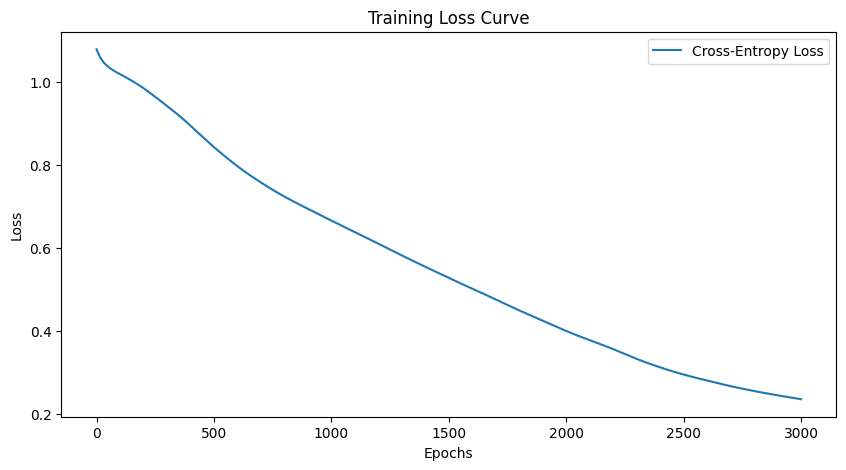

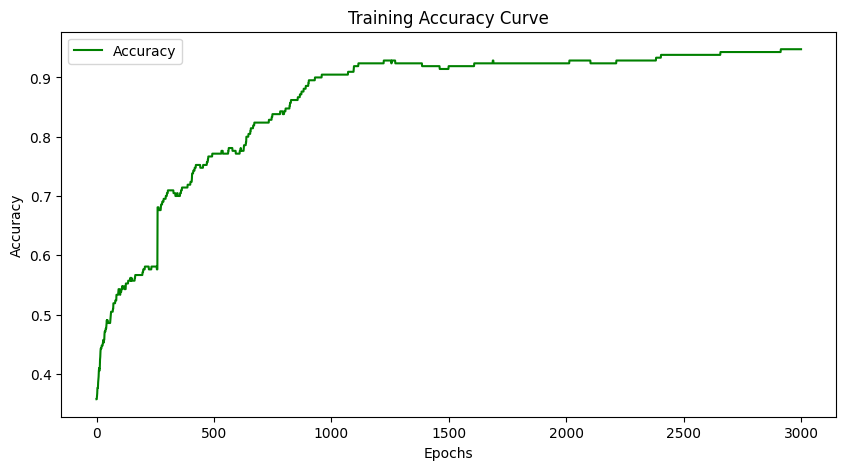

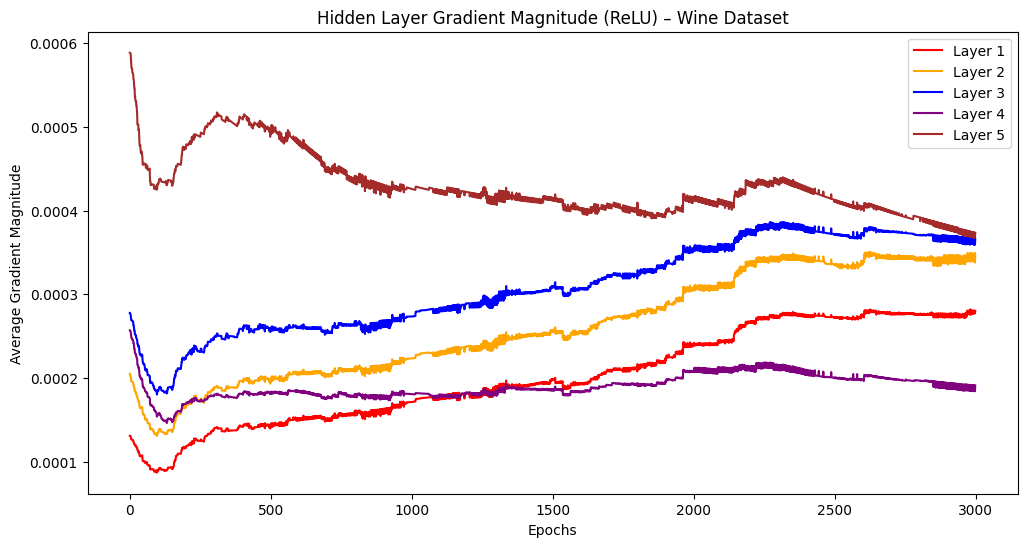

In [12]:
# ------------------------
# 6. Plot loss curve
# ------------------------
plt.figure(figsize=(10,5))
plt.plot(losses, label="Cross-Entropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# ------------------------
# 7. Plot accuracy curve
# ------------------------
plt.figure(figsize=(10,5))
plt.plot(accuracies, label="Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()
plt.show()

# ------------------------
# 8. Plot average gradient per layer (vanishing gradient demo)
# ------------------------
plt.figure(figsize=(12,6))
colors = ['red','orange','blue','purple','brown']
for i, grads in enumerate(grad_mags):
    plt.plot(grads, label=f"Layer {i+1}", color=colors[i])
plt.xlabel("Epochs")
plt.ylabel("Average Gradient Magnitude")
plt.title("Hidden Layer Gradient Magnitude (ReLU) – Wine Dataset")
plt.legend()
plt.show()

## Comparing weights before and after training

In [13]:
print("Weight magnitude comparison (mean absolute value):")
print("-" * 60)

hidden_sizes = [6, 5, 4, 3, 3]   # ← add this line

for i in range(len(hidden_sizes)):
    init_mag = np.mean(np.abs(init_hidden_w[i]))
    final_mag = np.mean(np.abs(final_hidden_w[i]))
    change = final_mag - init_mag
    print(f"Hidden Layer {i+1} ({hidden_sizes[i]} neurons):")
    print(f"  Initial mean |W| = {init_mag:.6f}")
    print(f"  Final   mean |W| = {final_mag:.6f}")
    print(f"  Change          = {change:+.6f}\n")

# Output layer
init_out_mag = np.mean(np.abs(init_out_w))
final_out_mag = np.mean(np.abs(final_out_w))
print("Output layer:")
print(f"  Initial mean |W| = {init_out_mag:.6f}")
print(f"  Final   mean |W| = {final_out_mag:.6f}")
print(f"  Change          = {final_out_mag - init_out_mag:+.6f}")

Weight magnitude comparison (mean absolute value):
------------------------------------------------------------
Hidden Layer 1 (6 neurons):
  Initial mean |W| = 0.398970
  Final   mean |W| = 0.402618
  Change          = +0.003648

Hidden Layer 2 (5 neurons):
  Initial mean |W| = 0.243448
  Final   mean |W| = 0.251351
  Change          = +0.007903

Hidden Layer 3 (4 neurons):
  Initial mean |W| = 0.332163
  Final   mean |W| = 0.344892
  Change          = +0.012729

Hidden Layer 4 (3 neurons):
  Initial mean |W| = 0.447512
  Final   mean |W| = 0.465278
  Change          = +0.017766

Hidden Layer 5 (3 neurons):
  Initial mean |W| = 0.455029
  Final   mean |W| = 0.500375
  Change          = +0.045346

Output layer:
  Initial mean |W| = 0.379195
  Final   mean |W| = 0.509800
  Change          = +0.130605


## Example of predicted instance

In [14]:
import numpy as np

# Example for one sample
idx = 204

# True label (integer)
true_label = y[idx]  # e.g., 0, 1, or 2

# Predicted probabilities for this sample
pred_prob = final_probs[idx]  # This should be an array of length = num_classes
pred_class = np.argmax(pred_prob)  # class with max probability

# Compute error as difference between predicted probability for true class vs 1
error = 1 - np.max(pred_prob)

# Confidence level based on max probability
confidence_score = np.max(pred_prob)
if confidence_score > 0.9:
    confidence = "Very high"
elif confidence_score > 0.7:
    confidence = "High"
elif confidence_score > 0.5:
    confidence = "Moderate"
else:
    confidence = "Low"

print(f"\nDetailed Prediction for One Sample (Actual Class = {true_label}):")
print(f"  Sample index:          {idx}")
print(f"  True class:            {true_label}")
print(f"  Predicted probabilities: {pred_prob}")
print(f"  Predicted class:       {pred_class+1} {'(correct)' if pred_class+1 == true_label else '(wrong)'}")
print(f"  Error (1 - true class probability): {error:.4f}")
print(f"  Confidence:            {confidence}")



Detailed Prediction for One Sample (Actual Class = 3):
  Sample index:          204
  True class:            3
  Predicted probabilities: [0.02006502 0.11848163 0.86145335]
  Predicted class:       3 (correct)
  Error (1 - true class probability): 0.1385
  Confidence:            High
